In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

from numba import njit, jit

from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement


0.0


/home/herbert/workspace/Thesis-VQE/entanglement_measures.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_matrix[ind_i][ind_j] = Bipartite_Negativity(rho_p)


In [2]:
TOKEN = "c969ef6706b30cef0669a46aff24f9c495d1a52e7632d03f1ede94cc6bd97fbc190d1cc5d23f1b914a448ea60b42c26f831f321bb7e0e151be887061d3139254"

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token= TOKEN,
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)
 
# Load saved credentials
service = QiskitRuntimeService()

# First Part: Initialize and compare results with different mappings

# Initialize the hamiltonian problem

In [26]:
#First we create the Hamiltonian as an observable of pauli matrices 

#@jit
def initialize_H2_vqe_chemical(intermolecular_distance= 0.7, mapper= JordanWignerMapper()):
    
    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {intermolecular_distance}", basis="sto-3g")
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()


    pauli_hamiltonian = mapper.map(hamiltonian)



    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)


    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz



#@jit
def run_calculation_for_gs(swept_interval, estimator):

    distances = swept_interval

    num_calc = len( swept_interval )

    entanglement_list_max = np.zeros(num_calc)
    entanglement_list_total = np.zeros(num_calc)

    negativity_list_max = np.zeros(num_calc)
    negativity_list_total = np.zeros(num_calc)

    ghz_measure_list = np.zeros(num_calc)

    energiesH2_list = np.zeros(num_calc)


    
    for i, d in enumerate(swept_interval):

        ansatz_h2, pauli_ham_h2, prob = initialize_H2_vqe_chemical(intermolecular_distance=d)

        gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                            ansatz= ansatz_h2,
                                                            problem= prob)
        

        r = DensityMatrix(optimal_ansatz_d)

    

        energiesH2_list[i] = gs_energy_d

        entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
        entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
        """
        negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
        negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
        """
        ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

    return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

        



In [4]:
distances = np.arange(0.05, 1.5, 0.05)

estimator = Estimator()


energiesH2, entgmax, entgtotal, negmax, negtotal, ghzmeasure = run_calculation_for_gs(swept_interval= distances, estimator= estimator)


     ┌────────────────────────────────────────────────┐
q_0: ┤0                                               ├
     │                                                │
q_1: ┤1                                               ├
     │  EvolvedOps(-1.5847e-07,-2.4212e-07,-0.036819) │
q_2: ┤2                                               ├
     │                                                │
q_3: ┤3                                               ├
     └────────────────────────────────────────────────┘
     ┌──────────────────────────────────────────────┐
q_0: ┤0                                             ├
     │                                              │
q_1: ┤1                                             ├
     │  EvolvedOps(1.0867e-07,1.6717e-07,-0.037931) │
q_2: ┤2                                             ├
     │                                              │
q_3: ┤3                                             ├
     └──────────────────────────────────────────────┘
     ┌────

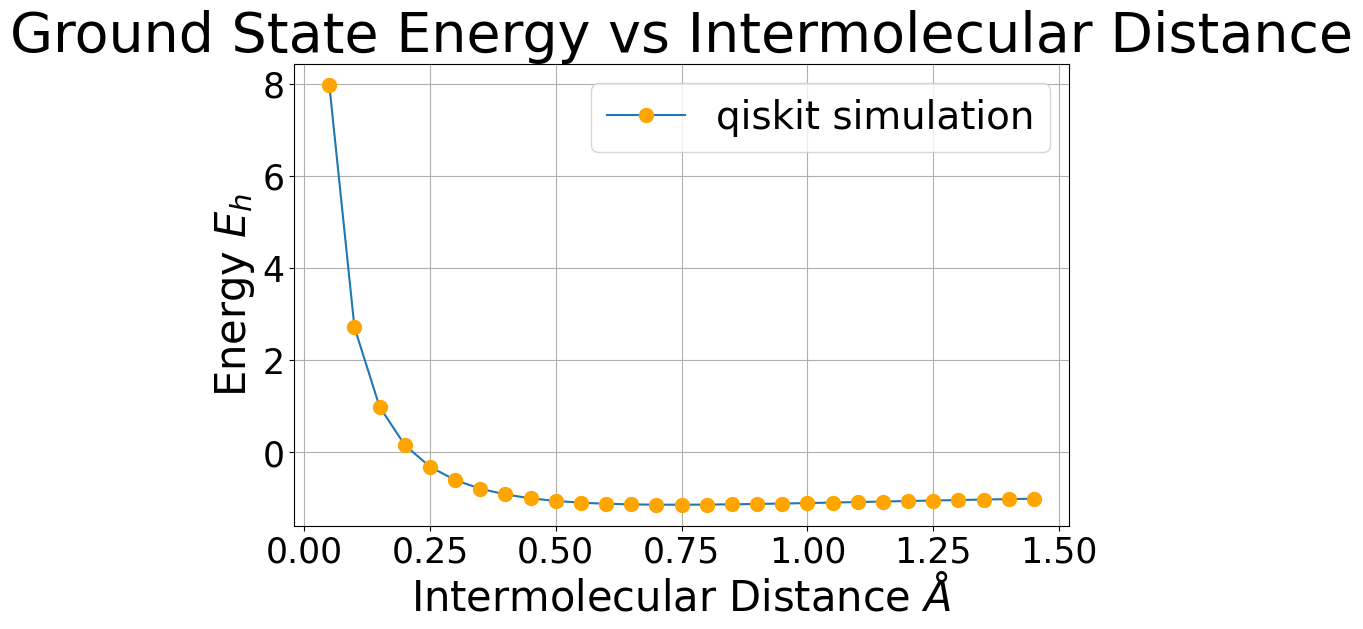

In [14]:
# Plotting the data

plt.figure(figsize=(10, 6))
plt.plot(distances, energiesH2, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy $E_h$', fontsize= 30)
plt.title(r'Ground State Energy vs Intermolecular Distance', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

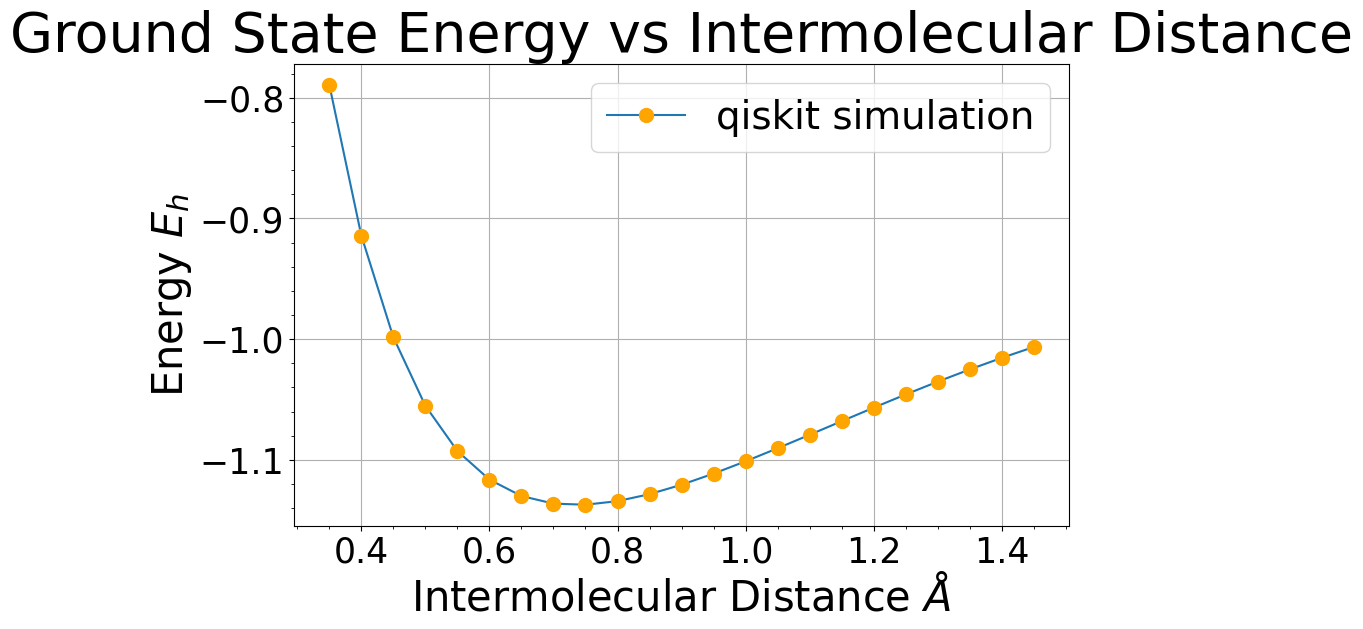

In [17]:

a = 6

b = -1

plt.figure(figsize=(10, 6))
plt.plot(distances[a:], energiesH2[a:], marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy $E_h$', fontsize= 30)
plt.title(r'Ground State Energy vs Intermolecular Distance', fontsize= 40)
plt.minorticks_on()  # Enable minor ticks

plt.grid(True)
plt.legend(fontsize= 28)

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

# Lets do the same wiht a bigger resolution...

In [30]:
distances = np.arange(0.5, 1, 0.005)

estimator = Estimator()


energiesH2_pt2, entgmax_pt2, entgtotal_pt2, negmax_pt2, negtotal_pt2, ghzmeasure_pt2 = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

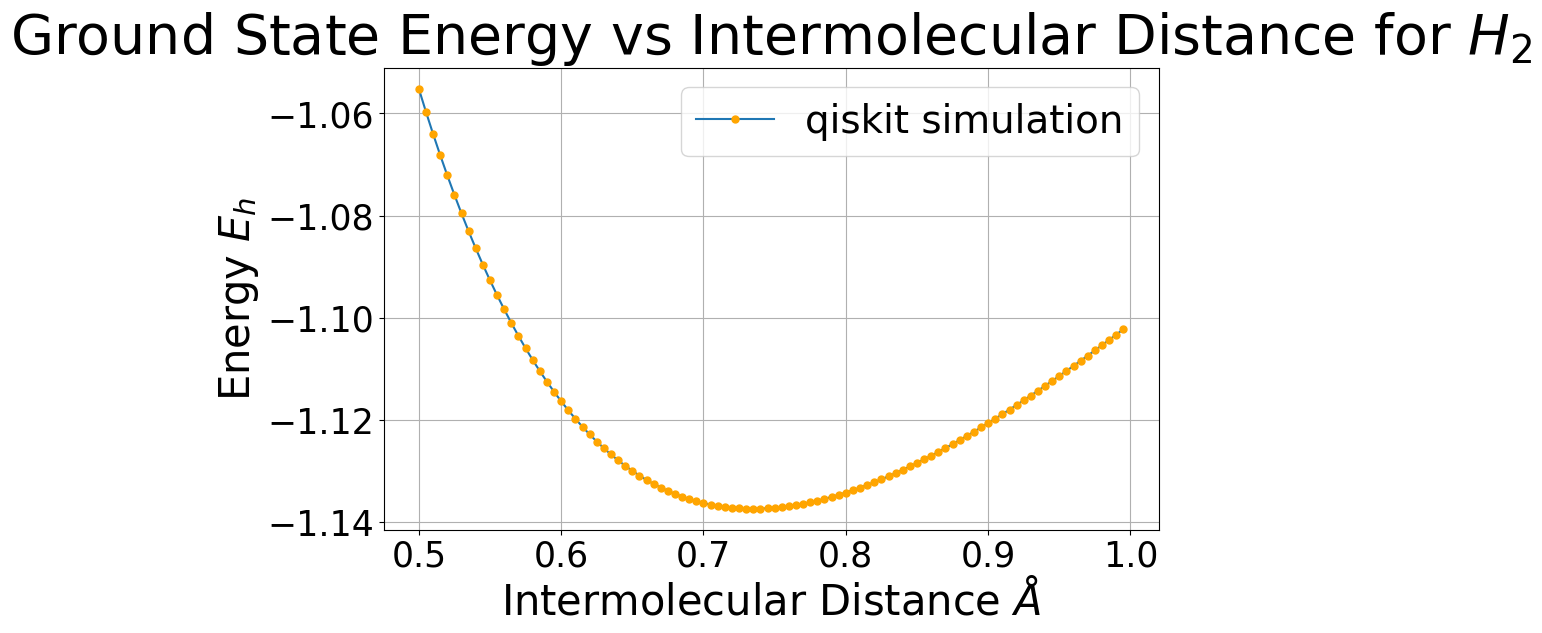

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(distances, energiesH2_pt2, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 5)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy $E_h$', fontsize= 30)
plt.title(r'Ground State Energy vs Intermolecular Distance for $H_2$', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

# Lets select the best ones

In [35]:
gs_energy = np.min(energiesH2_pt2)

gs_ener_indx = np.where(energiesH2_pt2 == gs_energy)[0][0]

minimal_distance = distances[gs_ener_indx]

print(f'Ground State Energy: {gs_energy} Hartree \n Distance of Equilibrium: {minimal_distance} Armstrongs')

Ground State Energy: -1.137306035695394 Hartree 
 Distance of Equilibrium: 0.7350000000000002 Armstrongs


# Now Study of entanglements, nothing surprising

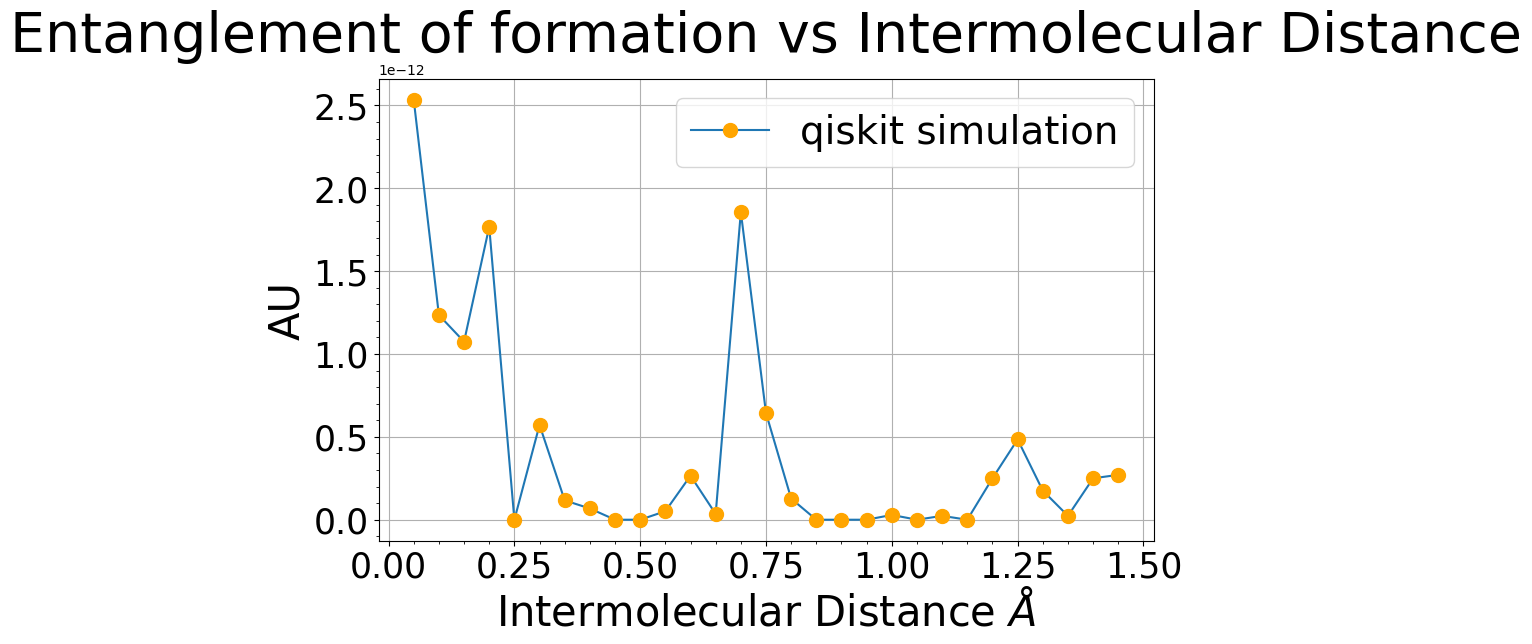

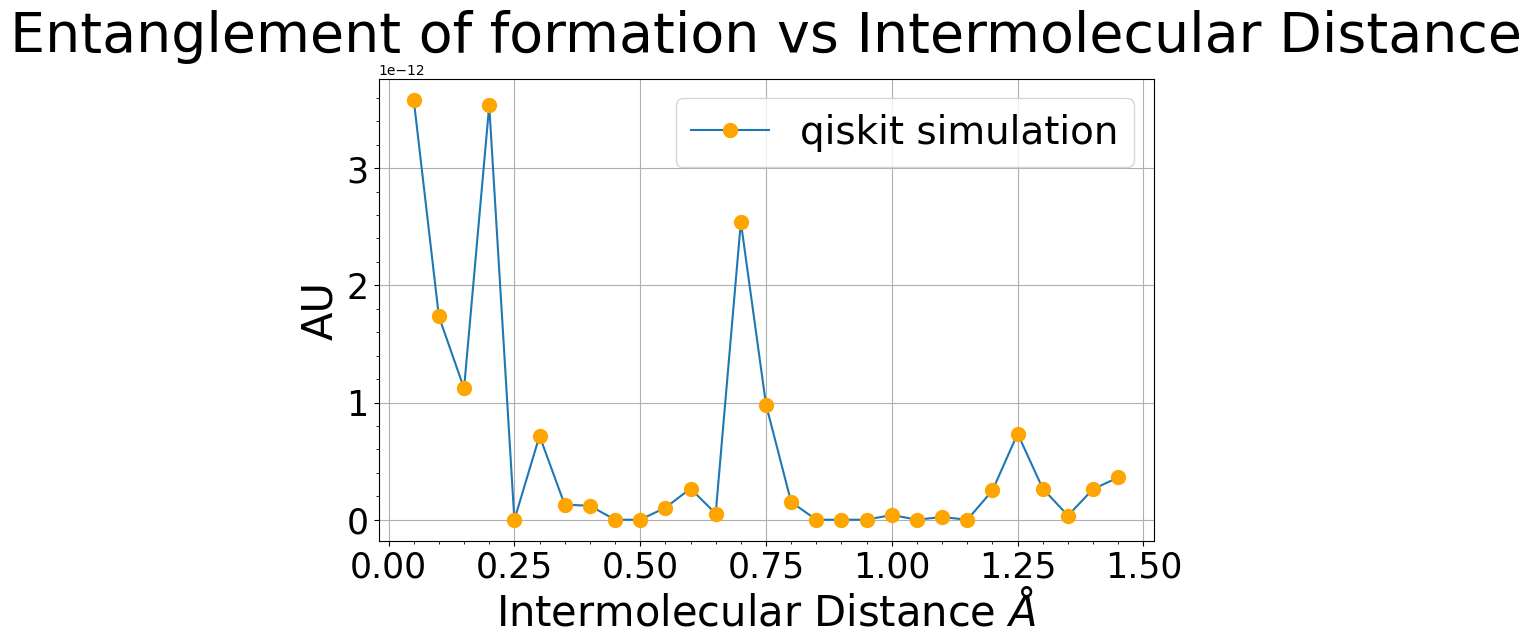

In [21]:
for data in (entgmax, entgtotal):


    plt.figure(figsize=(10, 6))
    plt.plot(distances, data, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
    plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
    plt.ylabel(f'AU', fontsize= 30)
    plt.title(r'Entanglement of formation vs Intermolecular Distance', fontsize= 40)
    plt.minorticks_on()  # Enable minor ticks

    plt.grid(True)
    plt.legend(fontsize= 28)

    plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

    plt.show()


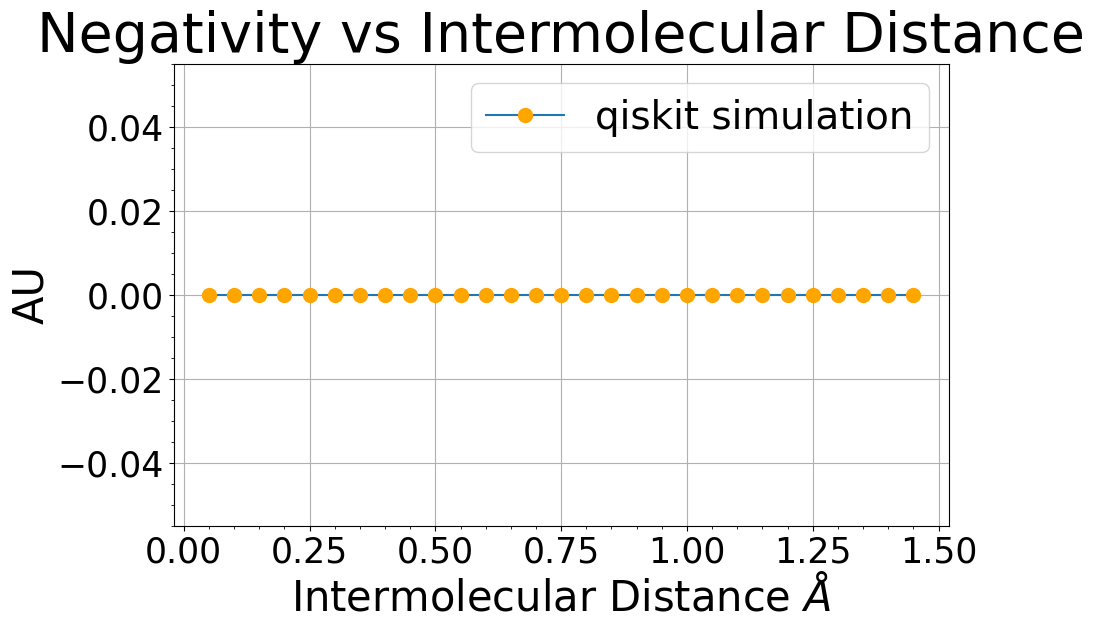

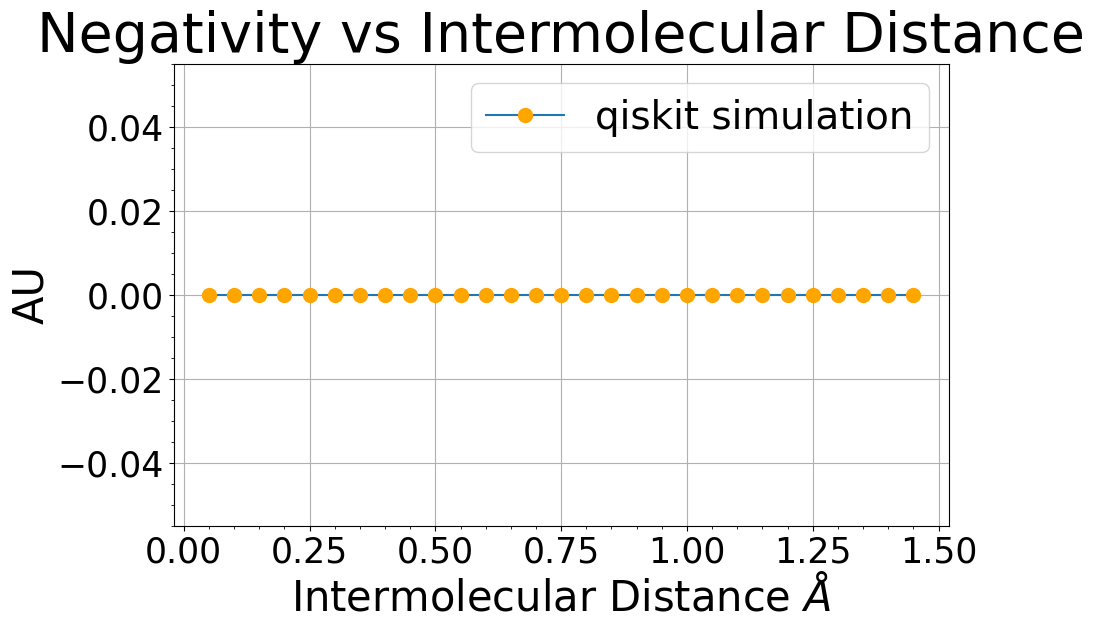

In [22]:
for data in (negmax, negtotal):


    plt.figure(figsize=(10, 6))
    plt.plot(distances, data, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
    plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
    plt.ylabel(f'AU', fontsize= 30)
    plt.title(r'Negativity vs Intermolecular Distance', fontsize= 40)
    plt.minorticks_on()  # Enable minor ticks

    plt.grid(True)
    plt.legend(fontsize= 28)

    plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

    plt.show()

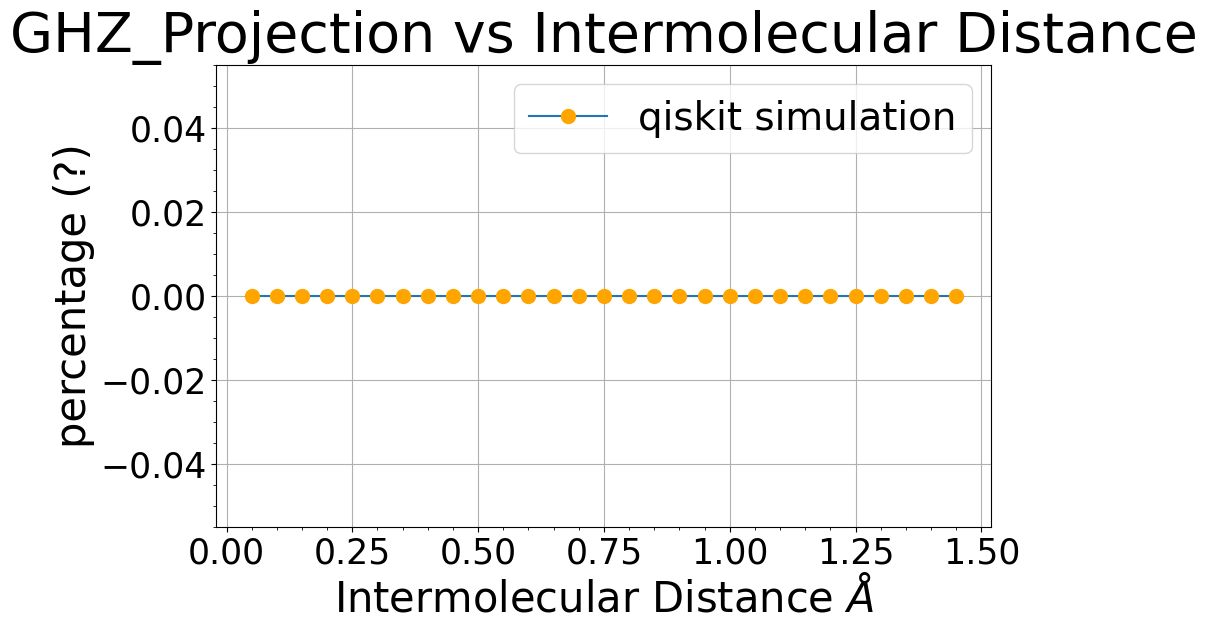

In [24]:

plt.figure(figsize=(10, 6))
plt.plot(distances, ghzmeasure, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(f'percentage (?)', fontsize= 30)
plt.title(r'GHZ_Projection vs Intermolecular Distance', fontsize= 40)
plt.minorticks_on()  # Enable minor ticks

plt.grid(True)
plt.legend(fontsize= 28)

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

In [6]:




from vqe_algorithm import cost_func

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

#init point:
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

backen = AerSimulator()




estimado = Estimator(backend= AerSimulator())
pass_manager = generate_preset_pass_manager(backend= ,
                                            optimization_level= 3)


cost_history_list = []
res_list = []

res = minimize(
    cost_func,
    x0,
    args=(ansatz, 
          ansatz, 
          pauli_hamiltonian, 
          estimado, 
          pass_manager, 
          cost_history_dict, 
          True),
    method= 'cobyla',
    options={'maxiter' : 400}
)

res_list.append(res)

print(cost_history_list["cost_history"])
cost_history_list.append(cost_history_dict["cost_history"])



SyntaxError: invalid syntax (732052110.py, line 18)

In [ ]:
print(cost_history_list)

[[array(-0.84923374), array(-1.24516316), array(-1.34857509), array(-0.49951571), array(-1.27432069), array(-1.40290906), array(-1.28682952), array(-1.27502555), array(-1.70820698), array(-1.81412285), array(-1.72996915), array(-1.85491363), array(-1.84966176), array(-1.84666689), array(-1.85224897), array(-1.87181974), array(-1.87451656), array(-1.8423222), array(-1.86004014), array(-1.8825636), array(-1.8766515), array(-1.88544232), array(-1.88816441), array(-1.88075389), array(-1.88584138), array(-1.88421591), array(-1.88863371), array(-1.88106477), array(-1.88435807), array(-1.88088901), array(-1.88742928), array(-1.8866208), array(-1.88354268), array(-1.88781375), array(-1.8908461), array(-1.89142388), array(-1.88790053), array(-1.89301686), array(-1.88019083), array(-1.88867352), array(-1.88420699), array(-1.88299944), array(-1.88462326), array(-1.88819127), array(-1.88757763), array(-1.88993562)]]


46


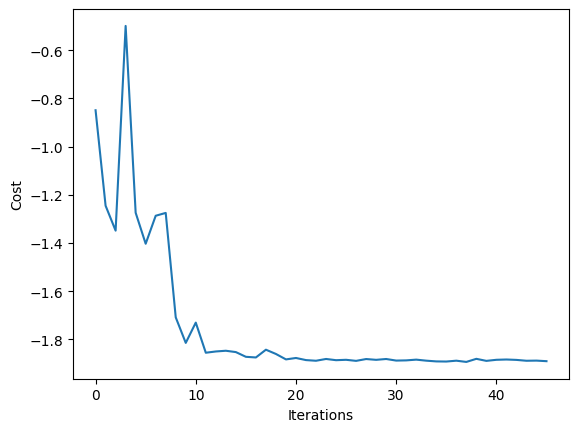

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"] )
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

print(cost_history_dict['iters'])




In [ ]:
distances = np.arange(0.05, 1.5, 0.05)


final_energies_AerSim = []
for d in distances:
    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    problem = driver.run()

    mapper = JordanWignerMapper()


    hamiltonian = problem.hamiltonian.second_q_op()
    pauli_hamiltonian = mapper.map(hamiltonian)


#then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    #initial point x0

    x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
    

    cost_history_list = []
    res_list = []

    res = minimize(
    cost_func,
    x0,
    args=(ansatz, 
          ansatz, 
          pauli_hamiltonian, 
          estimado, 
          pass_manager, 
          cost_history_dict, 
          True),
    method= 'cobyla',
    options={'maxiter' : 400}
    )

    final_energy = cost_history_dict["cost_history"][-1]

    final_energies_AerSim.append(final_energy)


6862


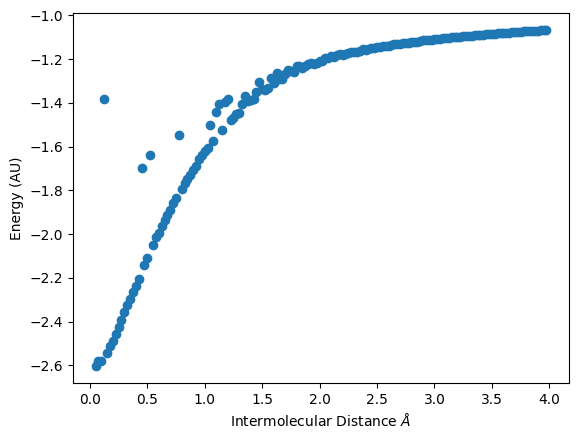

In [ ]:
fig, ax = plt.subplots()
ax.scatter(distances, final_energies_AerSim)
ax.set_xlabel(r'Intermolecular Distance $\AA$')
ax.set_ylabel(r'Energy (AU)')
plt.draw()

print(cost_history_dict['iters'])
